#    Compilers and Languages
## Programming assignment : Part 1 : input regex -> NFA

Table of Contents:
1. [The Shunting Yard Algorithm](#1.-Introduction---Shunting-Yard-Algorithm)
2. [Postfix to NFA](#2.-Postfix-to-NFA)

# The shunting yard algorithm (infix to postfix)

### Introduction
The shunting yard algorithm is a method for parsing mathematical expressions specified in infix notation. It can be used to produce output in Reverse Polish Notation (RPN) or as an abstract syntax tree (AST). The algorithm was invented by Edsger Dijkstra and named the "shunting yard" algorithm because its operation resembles that of a railroad shunting yard.

We will use the shunting yard algorithm to convert the regular expression to postfix notation, which will be used to create the NFA.

### Goal
converting something like `(A+B) * (C | D)` to `A+B . * CD |.`

### Features
. No recursion => Iterative approach.
. No trees are needed.
. No Ambiguities.
. Handles precedence of operators.

### Data Structures
1. infix (input regex) : The regular expression in infix notation (string)
   . Note : infix means the operator is between the operands. eg: `A+B` (The normal way we write expressions)
2. postfix : The regular expression in postfix notation (string)
    . Note : postfix means the operator is after the operands. eg: `AB+` (The way we write expressions in the shunting yard algorithm)
3. stack : The stack used in the algorithm (list)

### Algorithm
0. preprocess the infix to add a `.` between the operands where needed. (eg: `A(B|C)` => `A.(B|C)`). also substitute ranges like `a-z` with the union of all the characters in the range.
1. Create an empty stack for operators. Create an empty list for the output.
2. For each character in the infix :
    - If char is `(` or `[` => push to stack
    - If char is `)` or `]` => pop from stack until nearest matching `(` or `[` , append to output
    - If char is an operator => pop from stack until the top of the stack has a lower precedence than the current operator, then push the current operator to the stack
    - If char is an operand/normal character => append to output
3. Pop all the remaining operators from the stack and append to the output


In [1]:
# Important declarations
# -----------------------
# Dictionary containing the precedence of the operators
regex_operators_precedence = {
    '*' : 5,
    '+' : 4,
    '?' : 3,
    '.' : 2,
    '|' : 1,
    '(' : 0,
    ')' : 0
}

alphanumeric = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
alphabetic = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'


## Preprocessing ...

In [2]:
# Utility functions
# -----------------
def preprocess_regex(regex):
    """
    Preprocess the regex to do the following:
        1-[ranges] add OR's | between in square brackets characters
        2-[ranges] replace dash - with the corresponding sequence of characters with OR's between them
        3-add the missing '.' operators
    """
    #step 1 : add OR's | between in square brackets characters without -
    square_brackets_open = False
    for i in range(len(regex)):
        if regex[i] == '[':
            square_brackets_open = True
        elif regex[i] == ']':
            square_brackets_open = False
        elif square_brackets_open and regex[i] != '-' and regex[i] in alphanumeric and i+1 < len(regex) and regex[i+1] in alphanumeric:
            regex = regex[:i+1] + '|' + regex[i+1:]
    print(f"After step 1 : {regex}")
    #step 2 : replace dash - with the corresponding sequence of characters with OR's between them
    i = 0
    while i < len(regex):
        c = regex[i]
        print(f"i = {i}, c = {c}")
        if c == '-':
            #pop the last element from the stack
            first = regex[i-1] if regex[i-1] in alphanumeric else None
            if not first:
                raise ValueError('Range error: element after - is not alphanumeric')
            #access Char + 1
            last = regex[i + 1] if i+1 < len(regex) and regex[i+1] in alphanumeric else None
            if not last:
                raise ValueError('Range error: element after - is not alphanumeric')
            #throw the - operator from the regex
            operating_list = []
            for char in alphanumeric:
                if alphanumeric.index(char) > alphanumeric.index(first) and alphanumeric.index(char) < alphanumeric.index(last):
                    #append | between the characters
                    # if char != last:
                    operating_list.append('|')
                    operating_list.append(char)
            operating_list.append('|')
            #replace - in regex with the operating list
            #using i to get the index of the first character in the range
            regex = regex[:i] + ''.join(operating_list) + regex[i+1:]
            i += len(operating_list)
        i += 1

    print(f"After step 2 : {regex}")
    #step 3 : add the missing '.' operators
    check1_list = ['*', '+', '?', ')', ']']
    new_regex = ''
    for i,c in enumerate(regex):
        if i > 0 and c in check1_list and i+1 < len(regex) and regex[i+1] not in check1_list:
            new_regex += c + '.'
        elif c in alphanumeric and i+1 < len(regex) and ((regex[i+1] in alphanumeric) or regex[i+1] in ['(', '[']):
            new_regex += c + '.'
        else:
            new_regex += c
    print(f"After step 3 : {new_regex} Preprocessed!")
    return new_regex

In [3]:
def infix_to_postfix(regex):
    """
    Convert an infix regular expression to a postfix regular expression.

    Parameters:
    regex (str): The infix regular expression to convert to postfix.

    Returns:
    str: The postfix regular expression.
    """
    regex = preprocess_regex(regex)
    # Create a stack to hold the operators
    stack = []
    # Create a list to hold the postfix regular expression
    postfix = []
    # Iterate over the characters in the infix regular expression
    for index,char in enumerate(regex):
        #1. '(' or '[': Push it onto the stack
        if char == '(' or char == '[':
            stack.append(char)
        #2. ')' or ']': Pop operators from the stack and append them to the postfix list until '(' or '[' is found
        elif char == ')' :
            while stack[-1] != '(':
                postfix.append(stack.pop())
            #error handling : check empty stack
            if not stack:
                raise ValueError('Parentheses mismatch : found ")" in the stack without "("')
            stack.pop()
        elif char == ']':
            while stack[-1] != '[':
                postfix.append(stack.pop())
            #error handling : check empty stack
            if not stack:
                raise ValueError('Parentheses mismatch : found "]" in the stack without "["')
            stack.pop()
        #3. Operator: Pop operators from the stack and append them to the postfix list until an operator with lower precedence is found
        elif char in regex_operators_precedence:
            #checks:
            # 1. if the stack is not empty
            # 2. if the stack[-1] is an operator => meaning the last element in the stack is an operator
            # 3. if the precedence of the operator in the stack is greater than or equal to the precedence of the current operator
            while stack and stack[-1] in regex_operators_precedence and regex_operators_precedence[stack[-1]] >= regex_operators_precedence[char]:
                postfix.append(stack.pop())
            stack.append(char)
        #else: Append the character to the postfix list
        else:
            # A normal character => append it to the postfix list
            postfix.append(char)
        # empty the stack
    while stack:
        #error handling : check '(' in the stack
        if stack[-1] == '(':
            raise ValueError('Parentheses mismatch : found "(" in the stack without ")"')
        postfix.append(stack.pop())
    return ''.join(postfix)



In [4]:
# test cases
# ----------
def test (id,regex, expected_postfix):
    output =infix_to_postfix(regex)
    print(f"Test case #{id} : {regex} received : {output} expected : {expected_postfix} => Passed")
    assert output == expected_postfix

# test(1,'a+b*c', 'a+b*.c.')
# test(2,'[a-z]+', 'a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z+')
print(infix_to_postfix('[a-zA-Z]+'))
print(infix_to_postfix('[f-p0-9]+(a*bcd?|cde*)'))

print(infix_to_postfix('[a-c]?.(c|d)'))

print('All test cases passed!')

After step 1 : [a-z|A-Z]+
i = 0, c = [
i = 1, c = a
i = 2, c = -
i = 52, c = |
i = 53, c = A
i = 54, c = -
i = 104, c = ]
i = 105, c = +
After step 2 : [a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z]+
After step 3 : [a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z]+ Preprocessed!
ab|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|+
After step 1 : [f-p|0-9]+(a*bcd?|cde*)
i = 0, c = [
i = 1, c = f
i = 2, c = -
i = 22, c = |
i = 23, c = 0
i = 24, c = -
i = 42, c = ]
i = 43, c = +
i = 44, c = (
i = 45, c = a
i = 46, c = *
i = 47, c = b
i = 48, c = c
i = 49, c = d
i = 50, c = ?
i = 51, c = |
i = 52, c = c
i = 53, c = d
i = 54, c = e
i = 55, c = *
i = 56, c = )
After step 2 : [f|g|h|i|j|k|l|m|n|o|p|0|1|2|3|4|5|6|7|8|9]+(a*bcd?|cde*)
After step 3 : [f|g|h|i|j|k|l|m|n|o|p|0|1|2|3|4|5|6|7|8|9]+.(a*.b.c.d?.|c.d.e*) Preprocessed!
fg|

# Postfix to NFA

## OOP Classes

### edge
1. label : The label of the edge
2. destination : The destination state of the edge
### state
1. label : The label of the state
2. out_edges : The outgoing edges from the state

### NFA
1. start : The start state of the NFA
2. accept : The accept state of the NFA
3. inner_states : The inner states of the NFA

In [5]:
class edge:
      def __init__(self):
        self.label=None
        self.destination=None
      def __str__(self):
        return f"edge {self.label} going to {self.destination}"

In [6]:
class NFA_state:
  def __init__(self):
    self.label=None
    self.out_edges=[] #list of edges


  '''
  This function gets the direct neighbours from taking the Epsilon edge.
  just the direct neighbours.
  '''
  def get_epsilon_closure(self):
    closure = set()
    closure.add(self)
    for edge in self.out_edges:
      if edge.label == "ε":
        closure.add(edge.destination)
    return closure

  '''
    gets the direct neighbours from taking the Character input edge, just the direct neighbours.
  '''
  def get_char_closure(self, char):
    closure = set()
    for edge in self.out_edges:
      if edge.label == char:
        closure.add(edge.destination)
    return closure

  '''
    Returns a set of States reachable from taking Char edges recursively
  '''
  def get_reachable_states(self, char):
    reachable_states = set()
    for edge in self.out_edges:
      if edge.label == char:
        reachable_states.add(edge.destination)
        reachable_states = reachable_states.union(edge.destination.get_reachable_states(char))
    return reachable_states

  '''
    Returns a set of States reachable from taking Epsilon edges recursively
  '''
  def get_reachable_states_epsilon(self):
    reachable_states = set()
    for edge in self.out_edges:
      if edge.label == "ε":
        reachable_states.add(edge.destination)
        reachable_states = reachable_states.union(edge.destination.get_reachable_states_epsilon())
    return reachable_states



  def __repr__(self) -> str:
     return self.label
  def __eq__(self, other):
    return other.label == self.label
  def __ne__(self, other):
    return other.label != self.label
  def __hash__(self):
     return hash(self.label)

In [7]:
%pip install graphviz
from graphviz import Digraph


In [58]:
class NFA:

    def __init__(self, initial, acc, inner : list):
        self.start = initial
        self.accept = acc
        self.inner_states = inner


    '''
        takes a SuperState and an input Character,
        gets the Char closure from all the substates in the SuperState,
        then makes a new list of reachable states (as a candidate new SuperState), returns this list
    '''
    def generate_new_superstate(self, super_state, char):
        reachable_states = set()
        for state in super_state:
            reachable_states = reachable_states.union(state.get_char_closure(char))

        new_superstate = set()
        for state in reachable_states:
            new_superstate = new_superstate.union(state.get_epsilon_closure())


        return new_superstate

    def print_graph(self):
        '''
        print the graph in a visual way
        '''
        print("NFA graph:")
        for state in self.inner_states:
            print(f"State {state.label} :")
            for edge in state.out_edges:
                print(f"  {edge}")
        print(f"Start state : {self.start.label}")
        print(f"Accept state : {self.accept.label}")

    def visualize(self):
        '''
        Visualize the graph
        '''
        dot = Digraph()
        #distinguish accept states
        for state in self.inner_states:
            if state == self.accept:
                dot.node(state.label, shape="doublecircle")
            else:
                dot.node(state.label)

        #add edges
        for state in self.inner_states:
            for edge in state.out_edges:
                dot.edge(state.label, edge.destination.label, label=edge.label)
        #Top to bottom
        dot.graph_attr["rankdir"] = "BT"
        dot.graph_attr["rankdir"] = "TB"
        #Left to right
        dot.graph_attr["rankdir"] = "LR"
        #format
        dot.format = "png"
        #show
        dot.view()
        #save
        dot.save("NFA.png")
        return dot


    def __repr__(self) ->str:
      return self.start.label

## Algorithm
### Based on Thompson's construction algorithm
1. Create a stack for NFA fragments
2. For each character in the postfix :
   1. If char is an operand/normal character => create a new NFA fragment with the character as the label and push to stack
   2. If char is a `.` => pop 2 fragments from the stack, connect the accept state of the first fragment to the start state of the second fragment, and push the new fragment to the stack
   3. If char is a `|` => pop 2 fragments from the stack, create a new start state and connect it to the start states of the 2 fragments, create a new accept state and connect the accept states of the 2 fragments to the new accept state, and push the new fragment to the stack
   4. If char is a `*` => pop 1 fragment from the stack, create a new start state and connect it to the start state of the fragment, create a new accept state and connect the accept states of the fragment to the new accept state, and connect the accept state of the fragment to the start state of the fragment, and push the new fragment to the stack
   5. If char is a `+` => pop 1 fragment from the stack, create a new start state and connect it to the start state of the fragment, create a new accept state and connect the accept states of the fragment to the new accept state, and connect the accept state of the fragment to the start state of the fragment, and push the new fragment to the stack
   6. If char is a `?` => pop 1 fragment from the stack, create a new start state and connect it to the start state of the fragment, create a new accept state and connect the accept states of the fragment to the new accept state, and push the new fragment to the stack
3. The final NFA is the fragment left in the stack

In [59]:
# Important functions [Thomas Construction Algorithm]
# -------------------
'''
1. Create a new NFA for a given character
2. Concatenate two NFAs
3. Union of two NFAs
4. Zero or more of an NFA
5. One or more of an NFA
6. Zero or one of an NFA
'''

def create_nfa(char: str, id: int ,fragment_stack):
    '''
    Create a new NFA for a given character

    Parameters:
    char (str): The character to create the NFA for.
    id (int): The id of the new NFA, used to label the states.
    fragment_stack (list): The stack of NFA fragments.

    Returns:
    NFA: The NFA for the given character.
    '''
    #create two states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    #Dummy label in format of S0 , S1, S2, ...
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create an edge from initial to accept with the given character
    edg = edge()
    edg.label = char
    edg.destination = accept
    initial.out_edges.append(edg)
    #push the new NFA to the stack
    created_nfa = NFA(initial, accept, [initial, accept])
    fragment_stack.append(created_nfa)
    id += 2
    return created_nfa

def concatenate_nfas(fragment_stack):
    '''
    Concatenate two NFAs, popping them from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.

    Returns:
    NFA: The NFA resulting from concatenating the top two NFAs on the stack.
    '''
    #pop the top two NFAs from the stack
    nfa2 = fragment_stack.pop()
    nfa1 = fragment_stack.pop()
    #create an edge from the accept state of the first NFA to the start state of the second NFA
    edg = edge()
    edg.label = "ε"
    edg.destination = nfa2.start
    nfa1.accept.out_edges.append(edg)
    #push the concatenated NFA back to the stack
    concatenated_nfa = NFA(nfa1.start, nfa2.accept, nfa1.inner_states + nfa2.inner_states)
    fragment_stack.append(concatenated_nfa)
    return concatenated_nfa

def union_nfas(fragment_stack , id : int):
    '''
    Union of two NFAs, popping them from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from union of the top two NFAs on the stack.
    '''
    #pop the top two NFAs from the stack
    nfa2 = fragment_stack.pop()
    nfa1 = fragment_stack.pop()
    #create two new states for the new NFA
    '''
    [S0] --ε--> [nfa1.start] --ε--> [S1]
        |ε                          |
        ----> [nfa2.start] --  ε  --|
    '''
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create two edges from the new initial state to the start states of the two NFAs
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa1.start
    initial.out_edges.append(edg1)
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = nfa2.start
    initial.out_edges.append(edg2)
    #create two edges from the accept states of the two NFAs to the new accept state
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = accept
    nfa1.accept.out_edges.append(edg3)
    edg4 = edge()
    edg4.label = "ε"
    edg4.destination = accept
    nfa2.accept.out_edges.append(edg4)
    #push the union NFA back to the stack
    union_nfa = NFA(initial, accept, [initial, accept] + nfa1.inner_states + nfa2.inner_states )
    fragment_stack.append(union_nfa)
    id += 2
    return union_nfa

def zero_or_more_nfa(fragment_stack, id: int):
    '''
    Zero or more of an NFA, popping it from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from zero or more of the top NFA on the stack.
    '''
    #pop the top NFA from the stack
    nfa = fragment_stack.pop()
    #create two new states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create two edges from the new initial state to the start state of the NFA and to the new accept state
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa.start
    initial.out_edges.append(edg1)
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = accept
    initial.out_edges.append(edg2)
    #create two edges from the accept state of the NFA to the new accept state and to the initial state of the new NFA
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = initial
    nfa.accept.out_edges.append(edg3)
    edg4 = edge()
    edg4.label = "ε"
    edg4.destination = accept
    nfa.accept.out_edges.append(edg4)
    #push the zero or more NFA back to the stack
    zero_or_more_nfa = NFA(initial, accept, [initial, accept] + nfa.inner_states)
    fragment_stack.append(zero_or_more_nfa)
    id += 2
    return zero_or_more_nfa

def one_or_more_nfa(fragment_stack, id: int):
    '''
    One or more of an NFA, popping it from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from one or more of the top NFA on the stack.
    '''
    #pop the top NFA from the stack
    nfa = fragment_stack.pop()
    #create two new states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create an edge from the new initial state to the start state of the NFA
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa.start
    initial.out_edges.append(edg1)
    #create two edges from the accept state of the NFA to the new accept state and to the initial state of the new NFA
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = accept
    nfa.accept.out_edges.append(edg2)
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = initial
    nfa.accept.out_edges.append(edg3)
    #push the one or more NFA back to the stack
    one_or_more_nfa = NFA(initial, accept, [initial, accept] + nfa.inner_states)
    fragment_stack.append(one_or_more_nfa)
    id += 2
    return one_or_more_nfa

def zero_or_one_nfa(fragment_stack, id: int):
    '''
    Zero or one of an NFA, popping it from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from zero or one of the top NFA on the stack.
    '''
    #pop the top NFA from the stack
    nfa = fragment_stack.pop()
    #create two new states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create two edges from the new initial state to the start state of the NFA and to the new accept state
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa.start
    initial.out_edges.append(edg1)
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = accept
    initial.out_edges.append(edg2)
    #create an edge from the accept state of the NFA to the new accept state
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = accept
    nfa.accept.out_edges.append(edg3)
    #push the zero or one NFA back to the stack
    zero_or_one_nfa = NFA(initial, accept, [initial, accept] + nfa.inner_states)
    fragment_stack.append(zero_or_one_nfa)
    id += 2
    return zero_or_one_nfa


In [60]:
def thompson_construction_postfix_to_nfa(postfix):
    '''
    Convert a postfix regular expression to an NFA using the Thompson construction algorithm.

    Parameters:
    postfix (str): The postfix regular expression to convert to an NFA.

    Returns:
    NFA: The NFA resulting from the postfix regular expression.
    '''
    # Create an empty stack to hold the NFA fragments
    fragment_stack = []
    #dummy id for the states
    id = 0
    # Iterate over the characters in the postfix regular expression
    for char in postfix:
        if char in alphanumeric:
            create_nfa(char, id, fragment_stack)
        elif char == '.':
            concatenate_nfas(fragment_stack)
        elif char == '|':
            union_nfas(fragment_stack, id)
        elif char == '*':
            zero_or_more_nfa(fragment_stack, id)
        elif char == '+':
            one_or_more_nfa(fragment_stack, id)
        elif char == '?':
            zero_or_one_nfa(fragment_stack, id)
        else:
            raise ValueError(f'Invalid character in postfix regular expression: {char}')
        id += 2
    #adjust IDs
    normal_id = 0
    for i, state in enumerate(fragment_stack[0].inner_states):
        #if not accept state
        if state != fragment_stack[0].accept:
            state.label = f"S{normal_id}"
            normal_id += 1
    fragment_stack[0].accept.label = f"S{normal_id}"
    # Return the resulting NFA
    return fragment_stack.pop()



In [61]:
# Output NFA to JSON of the following format:
'''
{
"startingState": "S0",
"S0": {
"isTerminatingState": false,
"A": "S1",
"B": "S0"
},
"S1": {
"isTerminatingState": true,
"A": "S1",
"B": "S1"
}
}


'''

def nfa_to_json(nfa):
    '''
    Convert an NFA to a JSON representation.

    Parameters:
    nfa (NFA): The NFA to convert to JSON.

    Returns:
    str: The JSON representation of the NFA.
    '''
    json = '{\n'
    json += f'"startingState": "{nfa.start.label}",\n'
    for state in nfa.inner_states:
        json += f'"{state.label}":'
        json += '{\n'
        json += f'"isTerminatingState": {state == nfa.accept},\n'
        for edge in state.out_edges:
            json += f'"{edge.label}": "{edge.destination.label}",\n'
        json = json[:-2] + '\n'
        json += '},\n'
    json = json[:-2] + '\n'
    json += '}\n'
    #save to file
    with open('NFA.json', 'w') as f:
        f.write(json)
    return json


After step 1 : a|b*
i = 0, c = a
i = 1, c = |
i = 2, c = b
i = 3, c = *
After step 2 : a|b*
After step 3 : a|b* Preprocessed!
NFA graph:
State S0 :
  edge ε going to S1
  edge ε going to S3
State S7 :
State S1 :
  edge a going to S2
State S2 :
  edge ε going to S7
State S3 :
  edge ε going to S5
  edge ε going to S4
State S4 :
  edge ε going to S7
State S5 :
  edge b going to S6
State S6 :
  edge ε going to S3
  edge ε going to S4
Start state : S0
Accept state : S7
{
"startingState": "S0",
"S0":{
"isTerminatingState": False,
"ε": "S1",
"ε": "S3"
},
"S7":{
"isTerminatingState": True
},
"S1":{
"isTerminatingState": False,
"a": "S2"
},
"S2":{
"isTerminatingState": False,
"ε": "S7"
},
"S3":{
"isTerminatingState": False,
"ε": "S5",
"ε": "S4"
},
"S4":{
"isTerminatingState": False,
"ε": "S7"
},
"S5":{
"isTerminatingState": False,
"b": "S6"
},
"S6":{
"isTerminatingState": False,
"ε": "S3",
"ε": "S4"
}
}



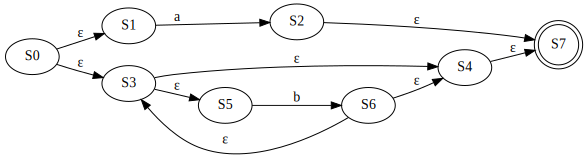

In [63]:
# Test cases
# ----------
def test_postfix_to_nfa(id, postfix, expected_nfa):
    nfa = thompson_construction_postfix_to_nfa(postfix)
    print(f"Test case #{id} : {postfix} received : {nfa} expected : {expected_nfa} => Passed")
    assert nfa == expected_nfa

# Test case 1
regex = 'a|b*'
postfix = infix_to_postfix(regex)
nfa = thompson_construction_postfix_to_nfa(postfix)
nfa.print_graph()
print(nfa_to_json(nfa))
nfa.visualize()

# Testing Cell : user input

Enter a regular expression: a*b?
After step 1 : a*b?
i = 0, c = a
i = 1, c = *
i = 2, c = b
i = 3, c = ?
After step 2 : a*b?
After step 3 : a*.b? Preprocessed!
NFA graph:
State S0 :
  edge ε going to S2
  edge ε going to S1
State S1 :
  edge ε going to S4
State S2 :
  edge a going to S3
State S3 :
  edge ε going to S0
  edge ε going to S1
State S4 :
  edge ε going to S5
  edge ε going to S7
State S7 :
State S5 :
  edge b going to S6
State S6 :
  edge ε going to S7
Start state : S0
Accept state : S7
NFA saved to NFA.json


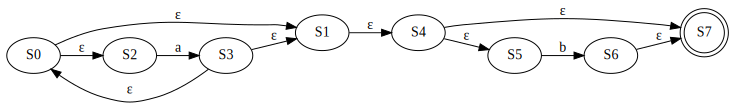

In [67]:
def test_user_input():
    regex = input("Enter a regular expression: ")
    postfix = infix_to_postfix(regex)
    nfa = thompson_construction_postfix_to_nfa(postfix)
    nfa.print_graph()
    nfa_to_json(nfa)
    print("NFA saved to NFA.json")
    return nfa

nfa = test_user_input()
nfa.visualize()